In [4]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 19.5 MB/s eta 0:00:00


In [6]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 109.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 103.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 105.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.1 MB/s eta 0:00:00


In [13]:
import os
import numpy as np
import cv2
from PIL import Image
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from transformers import ViTFeatureExtractor, TFViTForImageClassification
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

In [2]:
image_directory = '/content/drive/MyDrive/Skin_Conditions/'
SIZE = 128
dataset, label = [], []

categories = ['Acne', 'Carcinoma', 'Eczema', 'Keratosis', 'Milia', 'Rosacea']

for idx, category in enumerate(categories):
    path = os.path.join(image_directory, category)
    for image_name in os.listdir(path):
        if image_name.lower().endswith('.jpg'):
            image = cv2.imread(os.path.join(path, image_name))
            if image is not None:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = Image.fromarray(image).resize((SIZE, SIZE))
                dataset.append(np.array(image))
                label.append(idx)

dataset = np.array(dataset)
labels = np.array(label)

print(f"Dataset shape: {dataset.shape}")
print(f"Labels shape: {labels.shape}")

Dataset shape: (2414, 128, 128, 3)
Labels shape: (2414,)


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset, labels, test_size=0.20, random_state=42
)

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)


Training data shape: (1931, 128, 128, 3)
Test data shape: (483, 128, 128, 3)


In [4]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

def preprocess(images):
    inputs = feature_extractor(images=list(images), return_tensors='tf')
    return inputs['pixel_values']

# Preprocess datasets
X_train_processed = preprocess(X_train)
X_test_processed = preprocess(X_test)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [5]:

#loading the model
num_classes = len(categories)  # Total number of classes.

# Load pretrained ViT model and adjust output layer:
vit_model = TFViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',  # Pretrained weights from Google.
    num_labels=num_classes,  # Adapt model to your number of classes.
    ignore_mismatched_sizes=True  # Ignore mismatch warnings when changing output layer.
)

# Compile model:
vit_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),  # Small learning rate for fine-tuning.
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # Loss for multi-class.
    metrics=['accuracy']  # Evaluation metric.
)


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing TFViTForImageClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTForImageClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
history = vit_model.fit(
    X_train_processed, y_train,
    validation_split=0.1,  # 10% of training data for validation during training.
    epochs=50,  # Number of training cycles (adjustable).
    batch_size=16  # Number of images per training step.
)


Epoch 1/50
109/109 [==============================] - 114s 650ms/step - loss: 1.2631 - accuracy: 0.7530 - val_loss: 0.7702 - val_accuracy: 0.9175
Epoch 2/50
109/109 [==============================] - 73s 673ms/step - loss: 0.5299 - accuracy: 0.9436 - val_loss: 0.4325 - val_accuracy: 0.9433
Epoch 3/50
109/109 [==============================] - 73s 671ms/step - loss: 0.2885 - accuracy: 0.9787 - val_loss: 0.3546 - val_accuracy: 0.9330
Epoch 4/50
109/109 [==============================] - 73s 671ms/step - loss: 0.1885 - accuracy: 0.9919 - val_loss: 0.2383 - val_accuracy: 0.9536
Epoch 5/50
109/109 [==============================] - 71s 648ms/step - loss: 0.1336 - accuracy: 0.9988 - val_loss: 0.2165 - val_accuracy: 0.9639
Epoch 6/50
109/109 [==============================] - 73s 668ms/step - loss: 0.1032 - accuracy: 0.9994 - val_loss: 0.2079 - val_accuracy: 0.9485
Epoch 7/50
109/109 [==============================] - 73s 671ms/step - loss: 0.0832 - accuracy: 1.0000 - val_loss: 0.1964 - val_a

In [7]:
test_loss, test_acc = vit_model.evaluate(X_test_processed, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')  # Accuracy as percentage.


16/16 [==============================] - 6s 397ms/step - loss: 0.1249 - accuracy: 0.9752
Test accuracy: 97.52%


In [8]:
predictions = vit_model.predict(X_test_processed).logits  # Raw predictions.
predicted_classes = np.argmax(predictions, axis=1)  # Choose class with highest logit.

# Detailed classification report:
print(classification_report(y_test, predicted_classes, target_names=categories))


16/16 [==============================] - 9s 394ms/step
              precision    recall  f1-score   support

        Acne       0.96      0.96      0.96        78
   Carcinoma       0.99      0.99      0.99        88
      Eczema       0.94      0.95      0.94        63
   Keratosis       1.00      0.99      0.99        90
       Milia       0.99      1.00      0.99        93
     Rosacea       0.96      0.94      0.95        71

    accuracy                           0.98       483
   macro avg       0.97      0.97      0.97       483
weighted avg       0.98      0.98      0.98       483



<Figure size 1000x800 with 0 Axes>

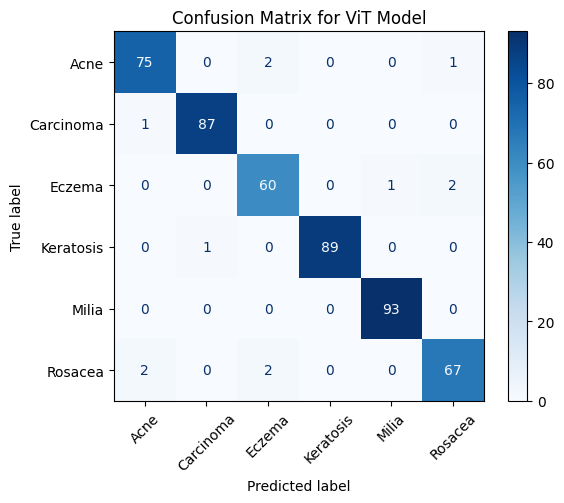

In [12]:
# Generate confusion matrix
cm = confusion_matrix(y_test, predicted_classes)

# Display confusion matrix visually
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix for ViT Model')
plt.show()

16/16 [==============================] - 6s 392ms/step


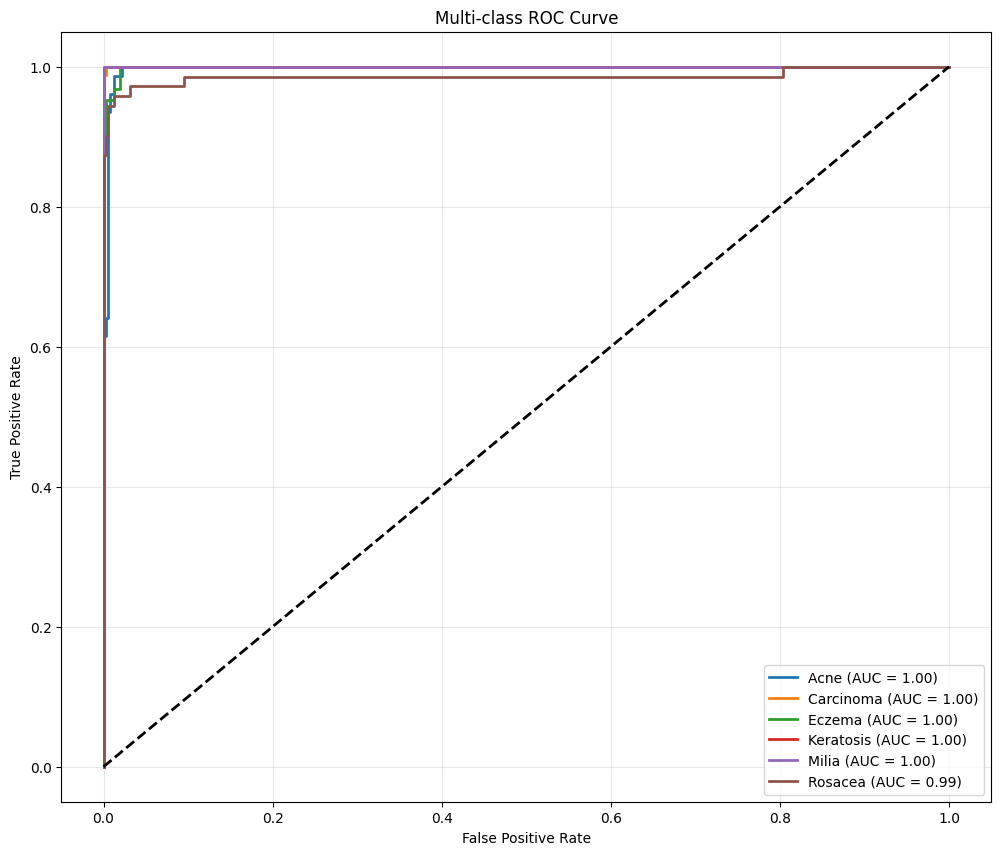

Average ROC-AUC score (macro-average): 1.00


In [14]:
# Binarize labels for multi-class ROC-AUC
num_classes = len(categories)
y_test_bin = label_binarize(y_test, classes=range(num_classes))

# Get predicted probabilities using softmax on logits
predictions = vit_model.predict(X_test_processed).logits
y_pred_prob = tf.nn.softmax(predictions, axis=1).numpy()

# Calculate ROC-AUC for each class
roc_auc_dict = {}
fpr = dict()
tpr = dict()

plt.figure(figsize=(12, 10))

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc_dict[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{categories[i]} (AUC = {roc_auc_dict[i]:.2f})')

# Plot diagonal line (random guessing)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Plot formatting
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

plt.show()

# Calculate and print average ROC-AUC
roc_auc_avg = roc_auc_score(y_test_bin, y_pred_prob, average='macro')
print(f"Average ROC-AUC score (macro-average): {roc_auc_avg:.2f}")

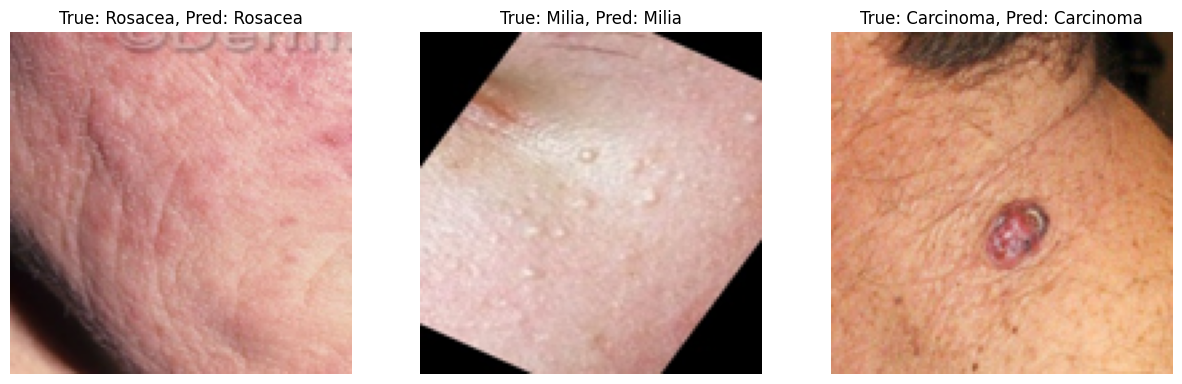

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    idx = random.randint(0, len(X_test)-1)  # Random sample from test set.
    axs[i].imshow(X_test[idx])  # Display original image.
    axs[i].axis('off')
    pred_label = categories[predicted_classes[idx]]  # Predicted category.
    true_label = categories[y_test[idx]]  # True category.
    axs[i].set_title(f"True: {true_label}, Pred: {pred_label}")  # Display prediction vs true label.

plt.show()  # Show the visualization.


In [15]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
import torch
import matplotlib.pyplot as plt

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", output_attentions=True)

inputs = feature_extractor(images=X_test[0], return_tensors="pt")
outputs = model(**inputs)
attentions = outputs.attentions  # attention maps available here


/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


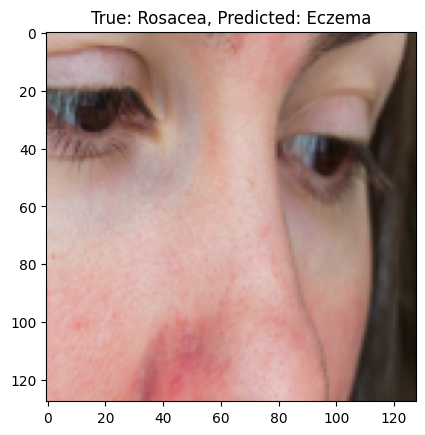

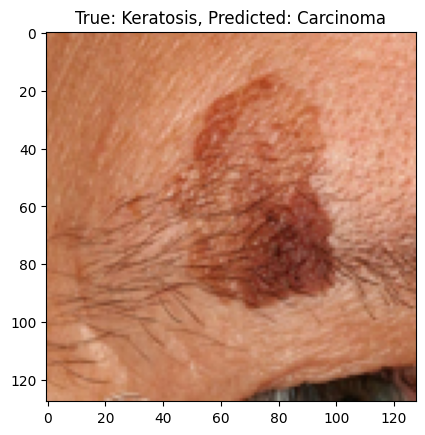

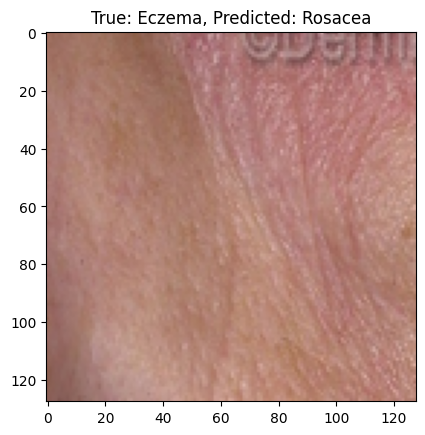

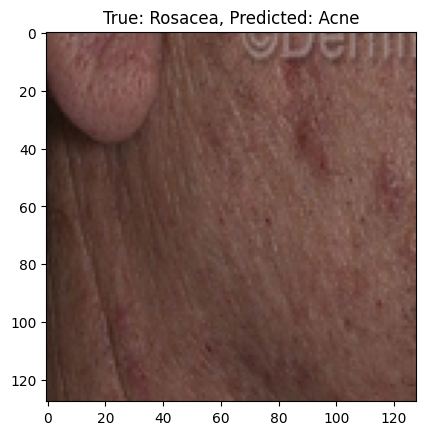

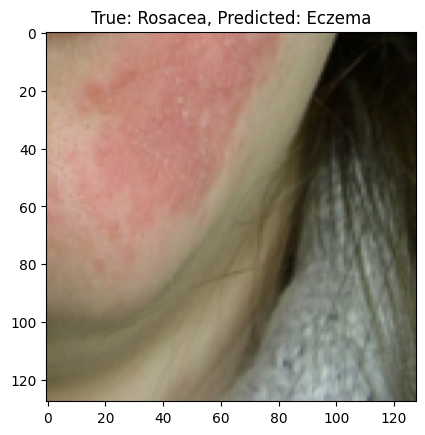

In [16]:

#error analysis
incorrect = np.where(predicted_classes != y_test)[0]

for idx in incorrect[:5]:  # Visualize first 5 incorrect predictions
    plt.imshow(X_test[idx])
    plt.title(f'True: {categories[y_test[idx]]}, Predicted: {categories[predicted_classes[idx]]}')
    plt.show()
